In [1]:
import os
import glob
import requests
import time
from shutil import copyfile
import pandas as pd
import numpy as np
from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances

%matplotlib inline

## Load images
- convert images to greyscale
- resize to 64 x 64
- load into numpy array and reshape to a 2D array

In [2]:
# read data
filelist = glob.glob('../../../data/zalando_models/kleider_small/*.jpg')
print('num images: ', len(filelist))

num images:  27324


# Get Feature Vectors

In [3]:
img_size = [64, 64]

In [4]:
def resize_image(img, size):
    return img.resize(size, Image.ANTIALIAS)

In [5]:
def get_image_feature(img_path):
    """Get the 64 byte array feature of the image"""

    url = 'http://akiwi.eu/mxnet/feature/'
    files = {'file': open(img_path, 'rb')}
    response = requests.post(url, files=files)

    if response.status_code == 200:
        response_feature = response.content
        return response_feature
    else:
        raise ValueError('Could not get feature vector for image. Response: ', response)

In [447]:
def transform_images(file_list, img_size, grayscale=True, edges=False, cut_heads=False):
    imgs = []
    for fname in file_list:
        # to avoid too many files open error
        img = Image.open(fname)
        img_copy = img.copy()
        imgs.append(img_copy)
        img.close()
    imgs = [resize_image(img, size=img_size) for img in imgs]
    if grayscale:
        imgs = [ImageOps.grayscale(img) for img in imgs]
    if edges:
        imgs = [img.filter(ImageFilter.FIND_EDGES) for img in imgs]
    if cut_heads:
        imgs = [np.array(img)[:20, 20:40] for img in imgs]
    X = np.array([np.array(img) for img in imgs])
    
    print('X.shape', X.shape)
    if grayscale:
        X = X.reshape([X.shape[0], X.shape[1] * X.shape[2]])
    else:
         X = X.reshape([X.shape[0], X.shape[1] * X.shape[2] * X.shape[3]])
    return X

In [12]:
def get_feature_dataframe(file_list, save_path, save_idx = 100):
    num_files = len(file_list)
    X = np.zeros([num_files, 64])
    for idx, file in enumerate(file_list):
        
        feature = get_image_feature(file)
        feature_vector = list(feature)
        assert len(feature_vector) == 64
        X[idx] = feature_vector
        
        if idx % save_idx == 0:
            np.save(save_path, X)
            print('Saving', idx)
    return X

In [242]:
data_path = '../../../data/zalando_models/'
save_file = os.path.join(data_path, 'kleider_features.npy')
filelist = sorted(filelist)
sampled_filelist = filelist

In [383]:
# X = get_feature_dataframe(filelist, save_file)
# X = np.load(save_file)
X = transform_images(sampled_filelist, img_size, edges=True)

In [385]:
X.shape

(27324, 4096)

## Cluster
Find 3 clusters - usually whole model image, zoomed model image and detail images

In [386]:
num_clusters = 3

In [387]:
m_km = KMeans(n_clusters=num_clusters)
m_km.fit(X)
m_clusters = m_km.labels_.tolist()

In [388]:
df = pd.DataFrame(list(zip(m_clusters, filelist)), columns=['cluster', 'path'])
df.groupby('cluster').count()

,path
cluster,
0,19351
1,4255
2,3718


#### Plot cluster centers

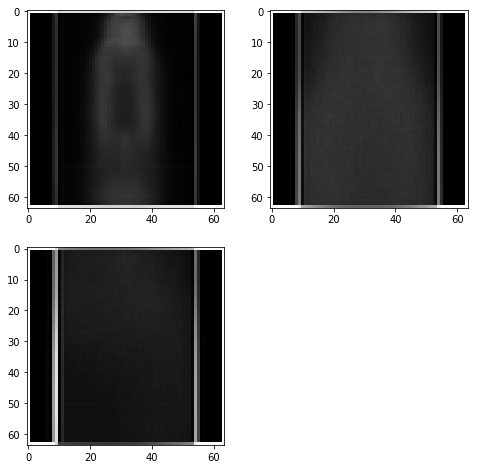

In [389]:
fig=plt.figure(figsize=(8, 8))
centers = np.array(m_km.cluster_centers_)
for idx, center in enumerate(centers):
    fig.add_subplot(2, 2, idx+1)
    center = center.reshape(img_size)
    img = Image.fromarray(center)
    plt.imshow(img)
plt.show()

#### Plot random sample of images that belong to each cluster

Cluster 0: 19351 images
Cluster 1: 4255 images
Cluster 2: 3718 images


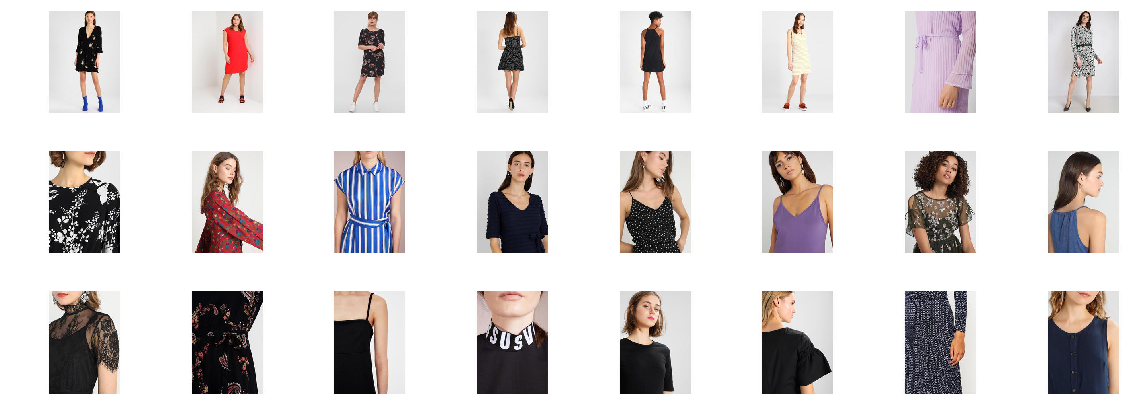

In [390]:
cluster_imgs = df.groupby('cluster').agg({'path': 'unique'})
fig=plt.figure(figsize=(16, 2*num_clusters))

i = 1
for cluster in cluster_imgs.index:
    imgs = cluster_imgs.loc[cluster, 'path'].tolist()
    print('Cluster {}: {} images'.format(cluster, len(imgs)))
    imgs = random.sample(imgs, 8)
    img_count = len(imgs)
    
#     ax = fig.add_subplot(num_clusters, 8, i)
#     ax.axis('off')
#     i += 1
#     center = np.array(m_km.cluster_centers_)[cluster]
#     center = center.reshape(img_size)
#     img = Image.fromarray(center)
#     plt.imshow(img)
    for idx, img_path in enumerate(imgs):
        ax = fig.add_subplot(num_clusters, 8, i)
        ax.axis('off')
        img = Image.open(img_path)
        plt.imshow(img)
        i += 1
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(data_path, 'kleider_images_edges3.jpg'))

In [391]:
np.random.seed(424)
test_imgs = np.random.choice(sampled_filelist, 10)
test_imgs = [os.path.basename(test_img).split('@')[0] for test_img in test_imgs if '@' in test_img]
test_imgs_all = [fname for fname in filelist if any(test_img in fname for test_img in test_imgs)]

In [392]:
df_test = df[df.path.isin(test_imgs_all)]
df_test = df_test.assign(img = df_test['path'].apply(lambda x: os.path.basename(x).split('@')[0]))
df_test.head()

,cluster,path,img
2430,1,../../../data/zalando_models/kleider_small/AN6...,AN621C0X4-G11
2431,0,../../../data/zalando_models/kleider_small/AN6...,AN621C0X4-G11
2432,0,../../../data/zalando_models/kleider_small/AN6...,AN621C0X4-G11
2433,0,../../../data/zalando_models/kleider_small/AN6...,AN621C0X4-G11
11964,1,../../../data/zalando_models/kleider_small/KM5...,KM521C058-Q11


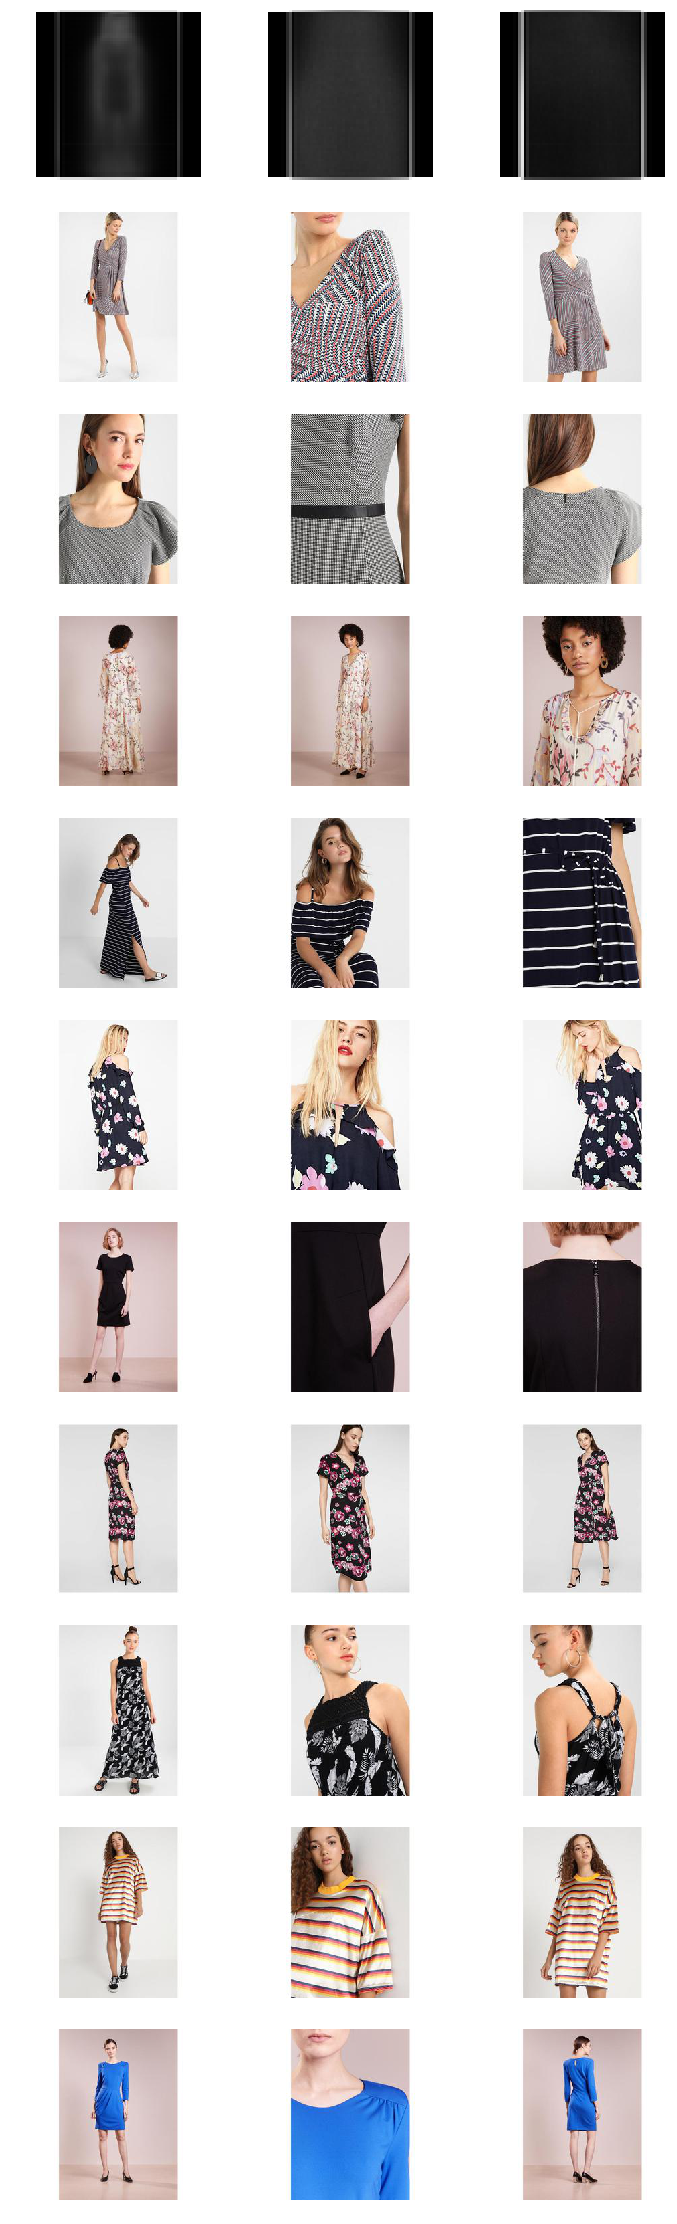

In [394]:
fig = plt.figure(figsize=(10,3*len(test_imgs)+1))
for idx, cluster_center in enumerate(m_km.cluster_centers_):
    ax = fig.add_subplot(len(test_imgs)+1, num_clusters, idx+1)
    ax.axis('off')
    center = cluster_center.reshape(img_size)
    img = Image.fromarray(center)
    plt.imshow(img)  

i = num_clusters
# i = 0
for idx, img in enumerate(df_test.img.unique().tolist()):
    img_paths = df_test[df_test.img == img]['path'].tolist()
#     imgs = np.array([list(get_image_feature(img)) for img in img_paths])
    imgs = transform_images(img_paths, img_size)
    distances = pairwise_distances(imgs, np.array(m_km.cluster_centers_))
    best_imgs = [0] * num_clusters
    for cluster in range(num_clusters):
        ind = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
        best_imgs[ind[1]] = ind[0]
        distances[ind[0], :] = np.inf
        distances[:, ind[1]] = np.inf
    
    for cluster in range(num_clusters):
        ax = fig.add_subplot(len(test_imgs)+1, num_clusters, i+1)
        ax.axis('off')
        img = Image.open(img_paths[best_imgs[cluster]])
        plt.imshow(img)
        i += 1
    
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(data_path, 'kleider_clusters_edges3.jpg'))

In [397]:
# Recluster
best_cluster_imgs = df.loc[df.cluster == 0, 'path'].tolist()
best_cluster_imgs[:10]

['../../../data/zalando_models/kleider_small/10K21C000-Q11@10.jpg',
 '../../../data/zalando_models/kleider_small/10K21C000-Q11@11.jpg',
 '../../../data/zalando_models/kleider_small/10K21C000-Q11@9.jpg',
 '../../../data/zalando_models/kleider_small/1479920167552.jpg',
 '../../../data/zalando_models/kleider_small/1480028912189.jpg',
 '../../../data/zalando_models/kleider_small/1481725719034.jpg',
 '../../../data/zalando_models/kleider_small/1484303952890.jpg',
 '../../../data/zalando_models/kleider_small/1484916915210.jpg',
 '../../../data/zalando_models/kleider_small/1484916917987.jpg',
 '../../../data/zalando_models/kleider_small/1486032027165.jpg']

In [448]:
X2 = transform_images(best_cluster_imgs, img_size, cut_heads=True, edges=True)

X.shape (19351, 20, 20)


In [449]:
X2.shape

(19351, 400)

In [450]:
m_km = KMeans(n_clusters=2)
m_km.fit(X2)
m_clusters = m_km.labels_.tolist()

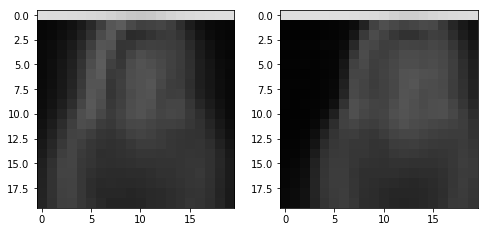

In [452]:
fig=plt.figure(figsize=(8, 8))
centers = np.array(m_km.cluster_centers_)
for idx, center in enumerate(centers):
    fig.add_subplot(2, 2, idx+1)
    center = center.reshape([20, 20])
    img = Image.fromarray(center)
    plt.imshow(img)
plt.show()

In [453]:
df = pd.DataFrame(list(zip(m_clusters, filelist)), columns=['cluster', 'path'])
df.groupby('cluster').count()

,path
cluster,
0,9221
1,10130


Cluster 0: 9221 images
Cluster 1: 10130 images


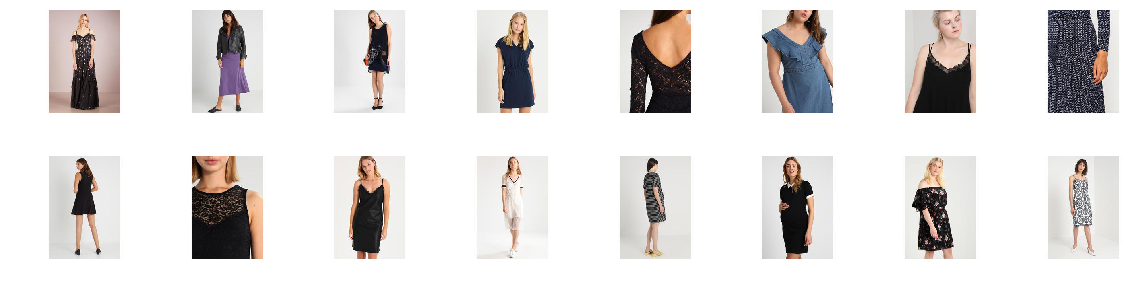

In [455]:
cluster_imgs = df.groupby('cluster').agg({'path': 'unique'})
fig=plt.figure(figsize=(16, 2*num_clusters))

i = 1
for cluster in cluster_imgs.index:
    imgs = cluster_imgs.loc[cluster, 'path'].tolist()
    print('Cluster {}: {} images'.format(cluster, len(imgs)))
    imgs = random.sample(imgs, 8)
    img_count = len(imgs)
    
#     ax = fig.add_subplot(num_clusters, 8, i)
#     ax.axis('off')
#     i += 1
#     center = np.array(m_km.cluster_centers_)[cluster]
#     center = center.reshape(img_size)
#     img = Image.fromarray(center)
#     plt.imshow(img)
    for idx, img_path in enumerate(imgs):
        ax = fig.add_subplot(num_clusters, 8, i)
        ax.axis('off')
        img = Image.open(img_path)
        plt.imshow(img)
        i += 1
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(data_path, 'kleider_images_edges3.jpg'))

## Save images
for each product, get all of its model images and identify the one closest to the best cluster center -> whole model image

In [ ]:
# best cluster center
cluster_center = np.array(m_km.cluster_centers_)[1]

# path to filtered images
filtered_folder = '../../../data/zalando_models/kleider_one/'

In [ ]:
orig_images = glob.glob('../../../data/zalando/kleider/*.jpg')
for idx, orig_img in enumerate(orig_images):
    if idx % 100 == 0:
        print(idx)
    
    img_name = os.path.basename(orig_img)
    
    try:
        model_imgs = [model_img for model_img in filelist 
                      if os.path.basename(model_img).split('@')[0] == img_name.split('.')[0]]

        # load all model images in greyscale and resized
        X = np.array([np.array(ImageOps.grayscale(resize_image(Image.open(fname), size=img_size))) for fname in model_imgs])
        X = X.reshape([X.shape[0], X.shape[1] * X.shape[2]])

        # calculate distance matrix
        distances = pairwise_distances(X, cluster_center.reshape(1, -1))
        best_img = model_imgs[distances.argmin()]
        dst_img = os.path.join(filtered_folder, img_name)
        copyfile(best_img, dst_img)
    except:
        print('Problem with image', img_name)